## Importing Libraries 

In [37]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation




## Load and Merge Datasets

In [38]:
#Merging the dataset 
df1 = pd.read_csv("../data/Citations updated.csv", encoding='ISO-8859-1') #citations
df2 = pd.read_csv("../data/reproducibility_stamp.csv", encoding='ISO-8859-1') #repStamp
merged_df = df1.merge(df2[['Title','DOI']], on ='Title', how='left',suffixes=('', '_from_Rep_Sta'))
merged_df['DOI'] = merged_df['DOI'].combine_first(merged_df['DOI_from_Rep_Sta'])
merged_df.head()
merged_df.drop(columns=['DOI_from_Rep_Sta'],inplace=True)
merged_df.to_csv(r'../data/merged_data.csv', index=False, encoding='ISO-8859-1')
#merged citations.csv with reproducibility_stamp, now the rows with a DOI are of reports with reproducibility stamps


Null Value Check

In [39]:
#Checking for null values, verifying data types 
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ï»¿Cites        1400 non-null   int64  
 1   Authors         1400 non-null   object 
 2   Title           1400 non-null   object 
 3   Year            1400 non-null   int64  
 4   Source          1398 non-null   object 
 5   Publisher       1391 non-null   object 
 6   ArticleURL      1337 non-null   object 
 7   CitesURL        1204 non-null   object 
 8   GSRank          1400 non-null   int64  
 9   QueryDate       1400 non-null   object 
 10  Type            278 non-null    object 
 11  DOI             88 non-null     object 
 12  ISSN            0 non-null      float64
 13  CitationURL     0 non-null      float64
 14  Volume          0 non-null      float64
 15  Issue           0 non-null      float64
 16  StartPage       0 non-null      float64
 17  EndPage         0 non-null      f

Correlation Matrix

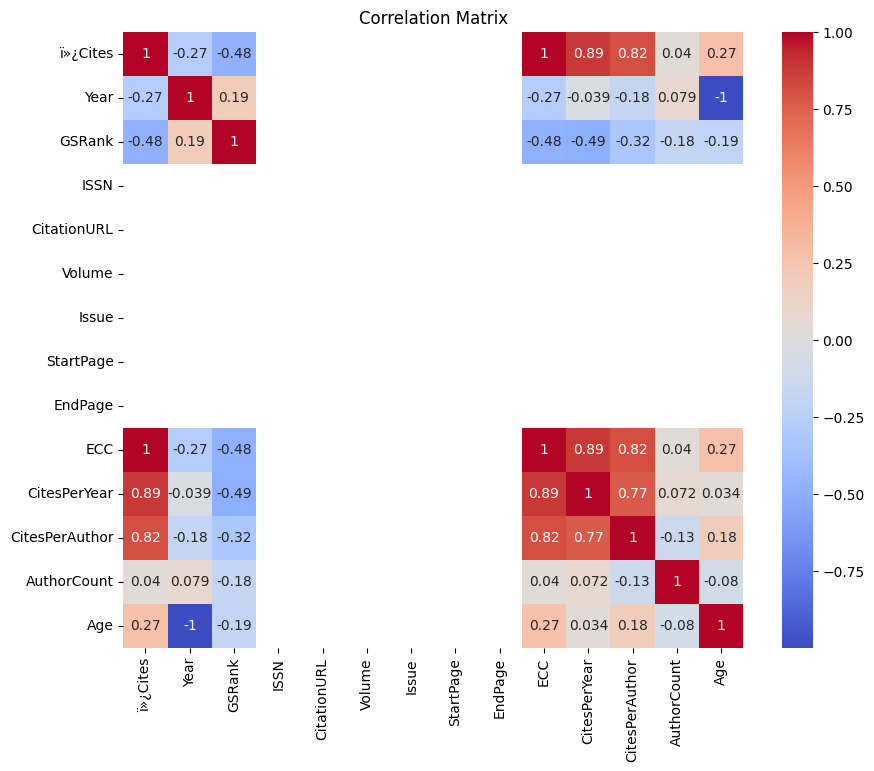

In [40]:
#Correlation matrix 
corr_matrix = merged_df.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## Data Cleaning and Pre-processing

Remove columns with no futher use

In [41]:

coloumns_to_drop = ['Source', 'ArticleURL', 'CitesURL', 'ISSN', 'Volume', 'Issue', 'StartPage', 'EndPage', 'CitationURL', 'FullTextURL', 'RelatedURL']
merged_df.drop(columns=coloumns_to_drop, inplace=True, errors='ignore')


Create a binary variable for reproducbility stamp

In [42]:
merged_df['IsReproducible?'] = merged_df['DOI'].notnull().astype(int) # added a reproducible boolean
merged_df.to_csv('./test.csv', index=False, encoding='ISO-8859-1')

## Statistical Testing

In [43]:

#from scipy.stats import mannwhitneyu

# Separate the two groups
reproducible = merged_df[merged_df['IsReproducible?'] == 1]['CitesPerYear']
non_reproducible = merged_df[merged_df['IsReproducible?'] == 0]['CitesPerYear']

# Perform the Mann-Whitney U Test
stat, p = mannwhitneyu(reproducible, non_reproducible)

print(f"U Statistic = {stat}")
print(f"P-value = {p}")

# Interpretation
if p < 0.05:
    print("Result: Significant difference between reproducible and non-reproducible papers ")
else:
    print("Result: No significant difference detected")


U Statistic = 62560.0
P-value = 0.18719227466326283
Result: No significant difference detected


In [44]:

# Define features and target
X = merged_df[['IsReproducible?', 'AuthorCount', 'Age']]
X = sm.add_constant(X)  # Adds intercept
y = merged_df['CitesPerYear']

# Fit the model
model = sm.OLS(y, X).fit()

# Show summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           CitesPerYear   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.208
Date:                Sat, 12 Apr 2025   Prob (F-statistic):             0.0223
Time:                        16:44:16   Log-Likelihood:                -4217.2
No. Observations:                1400   AIC:                             8442.
Df Residuals:                    1396   BIC:                             8463.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.6290      0.451     

## Exploratory Data Analysis (EDA)

Boxplot: CitesPerYear vs Reproducibility

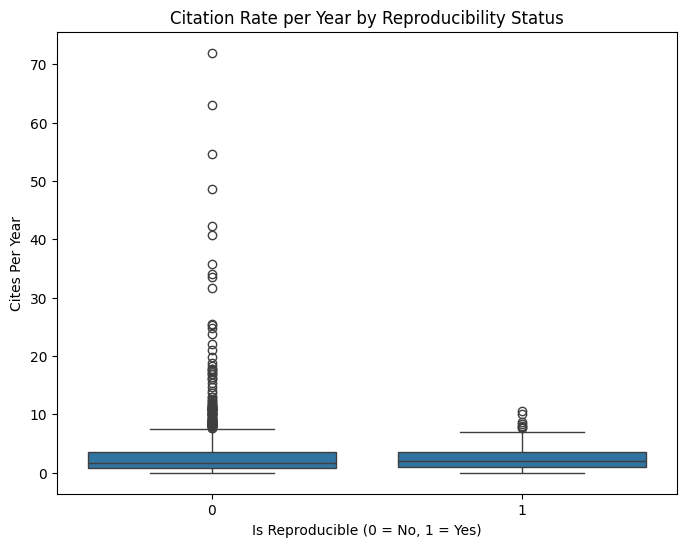

In [45]:
plt.figure(figsize=(8,6))
sns.boxplot(data=merged_df, x='IsReproducible?', y='CitesPerYear')
plt.title('Citation Rate per Year by Reproducibility Status')
plt.xlabel('Is Reproducible (0 = No, 1 = Yes)')
plt.ylabel('Cites Per Year')
plt.show()


 Scatterplot: Age vs CitesPerYear, Colored by Reproducibility

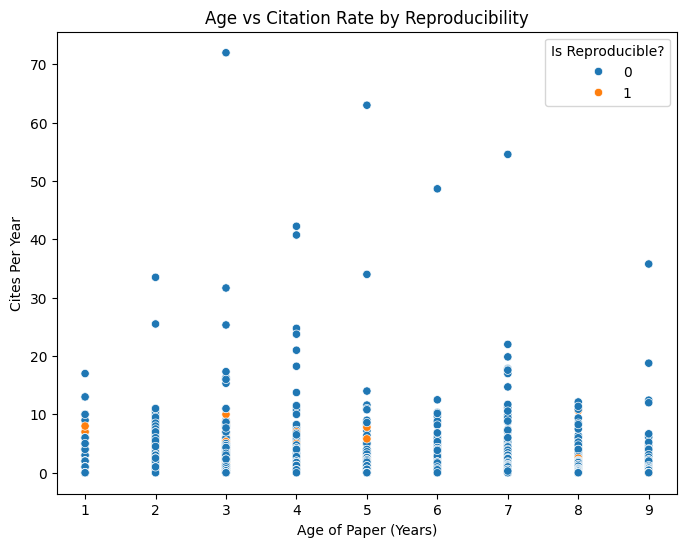

In [46]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x='Age', y='CitesPerYear', hue='IsReproducible?')
plt.title('Age vs Citation Rate by Reproducibility')
plt.xlabel('Age of Paper (Years)')
plt.ylabel('Cites Per Year')
plt.legend(title='Is Reproducible?')
plt.show()


Barplot: Average CitesPerYear for Reproducible vs Non-Reproducible

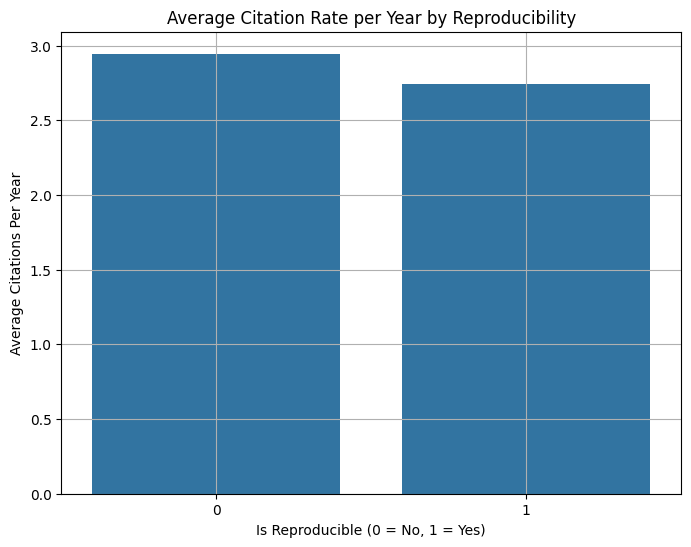

In [47]:
plt.figure(figsize=(8,6))
avg_cites = merged_df.groupby('IsReproducible?')['CitesPerYear'].mean().reset_index()

sns.barplot(data=avg_cites, x='IsReproducible?', y='CitesPerYear')
plt.title('Average Citation Rate per Year by Reproducibility')
plt.xlabel('Is Reproducible (0 = No, 1 = Yes)')
plt.ylabel('Average Citations Per Year')
plt.grid(True)
plt.show()


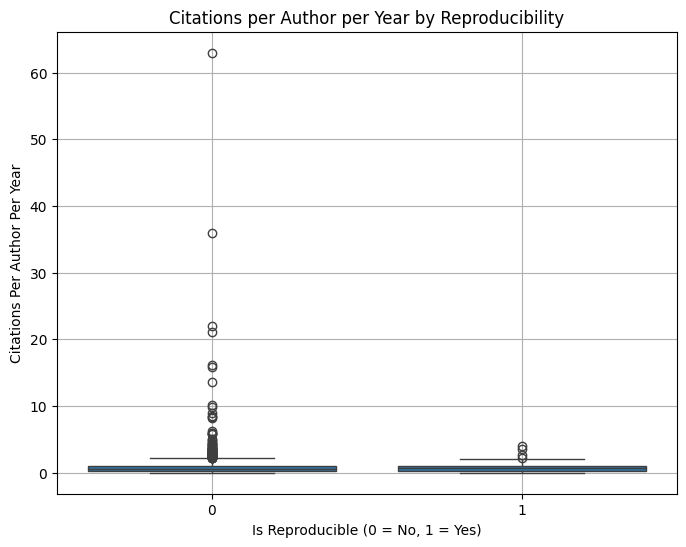

In [48]:
merged_df['CitesPerAuthorPerYear'] = merged_df['CitesPerYear'] / merged_df['AuthorCount']

plt.figure(figsize=(8,6))
sns.boxplot(data=merged_df, x='IsReproducible?', y='CitesPerAuthorPerYear')
plt.title('Citations per Author per Year by Reproducibility')
plt.xlabel('Is Reproducible (0 = No, 1 = Yes)')
plt.ylabel('Citations Per Author Per Year')
plt.grid(True)
plt.show()


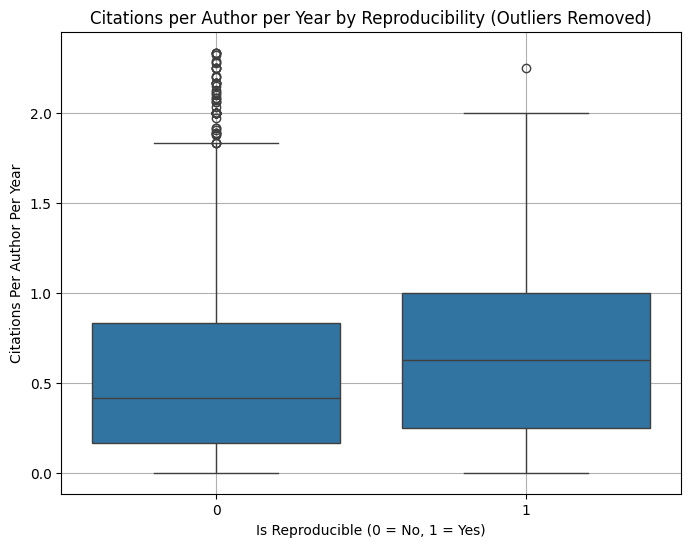

In [49]:

# Calculate 95th percentile value
q95 = merged_df['CitesPerAuthorPerYear'].quantile(0.95)

# Keep only rows below the 95th percentile
df_no_outliers = merged_df[merged_df['CitesPerAuthorPerYear'] <= q95]






plt.figure(figsize=(8,6))
sns.boxplot(data=df_no_outliers, x='IsReproducible?', y='CitesPerAuthorPerYear')
plt.title('Citations per Author per Year by Reproducibility (Outliers Removed)')
plt.xlabel('Is Reproducible (0 = No, 1 = Yes)')
plt.ylabel('Citations Per Author Per Year')
plt.grid(True)
plt.show()


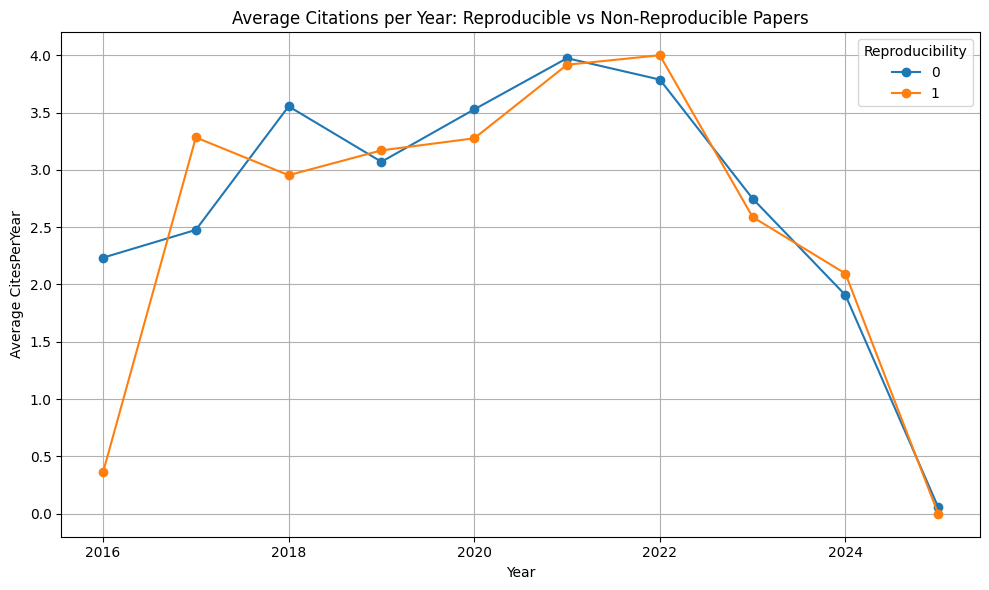

In [50]:
#import pandas as pd
#import matplotlib.pyplot as plt

# Load your dataset (skip this if already loaded)
# merged_df = pd.read_csv("your_dataset.csv")

# Drop rows with missing values in relevant columns
df = merged_df.dropna(subset=['Year', 'CitesPerYear', 'IsReproducible?'])

# Ensure Year is integer and is_reproducible is categorical
df['Year'] = df['Year'].astype(int)
df['IsReproducible?'] = df['IsReproducible?'].astype(str)

# Group by year and reproducibility and calculate average citations
grouped = df.groupby(['Year', 'IsReproducible?'])['CitesPerYear'].mean().reset_index()

# Pivot for plotting
pivot_df = grouped.pivot(index='Year', columns='IsReproducible?', values='CitesPerYear')

# Plotting
pivot_df.plot(kind='line', marker='o', figsize=(10, 6))
plt.title("Average Citations per Year: Reproducible vs Non-Reproducible Papers")
plt.xlabel("Year")
plt.ylabel("Average CitesPerYear")
plt.legend(title="Reproducibility")
plt.grid(True)
plt.tight_layout()
plt.show()


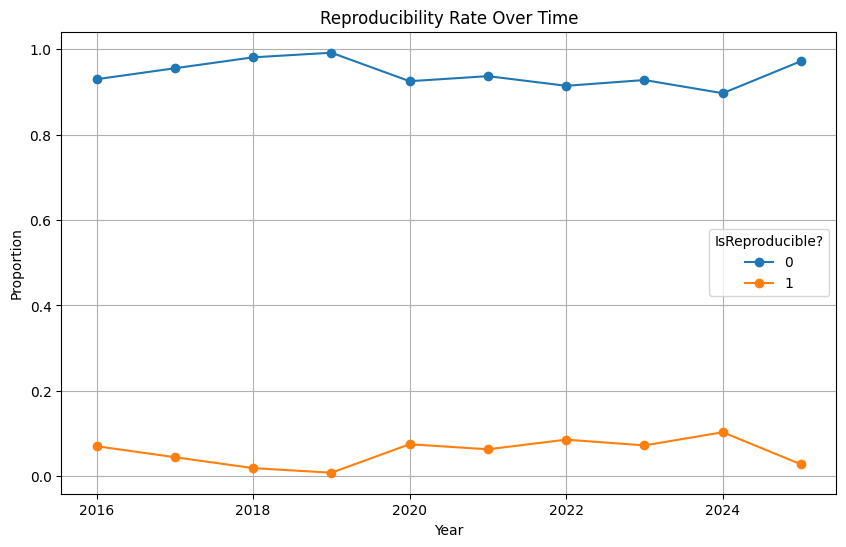

In [51]:
repro_rate = merged_df.groupby('Year')['IsReproducible?'].value_counts(normalize=True).unstack()
repro_rate.plot(kind='line', marker='o', figsize=(10,6))
plt.title("Reproducibility Rate Over Time")
plt.ylabel("Proportion")
plt.grid(True)
plt.show()


In [52]:
#import pandas as pd

# Load  merged dataset
#merged_df = pd.read_csv("../notebooks/test.csv", encoding="ISO-8859-1")

# Drop rows with missing citation data or year
#filtered_df = merged_df.dropna(subset=["CitesPerYear", "Year"])

# Get the most cited paper per year
most_cited_per_year = (
    df.sort_values(by="CitesPerYear", ascending=False)
    .groupby("Year", as_index=False)
    .first()
)

# Sort and select the top 10 most cited among those
top_10 = most_cited_per_year.sort_values(by="CitesPerYear", ascending=False).head(10)

# Show only Title, Year, and CitesPerYear
top_10[["Title", "Year", "CitesPerYear"]]


,Title,Year,CitesPerYear
6,A survey of visual analytics for explainable a...,2022,72.00
4,ConvPoint: Continuous convolutions for point c...,2020,63.00
2,SnapNet: 3D point cloud semantic labeling with...,2018,54.57
3,Human pose regression by combining indirect pa...,2019,48.67
5,A robot arm digital twin utilising reinforceme...,2021,42.25
0,Automatic reconstruction of parametric buildin...,2016,35.78
7,A review on generative adversarial networks fo...,2023,33.50
8,A survey of efficient fine-tuning methods for ...,2024,17.00
1,A multi-view recurrent neural network for 3D m...,2017,12.13
9,An introduction to and survey of biological ne...,2025,1.00


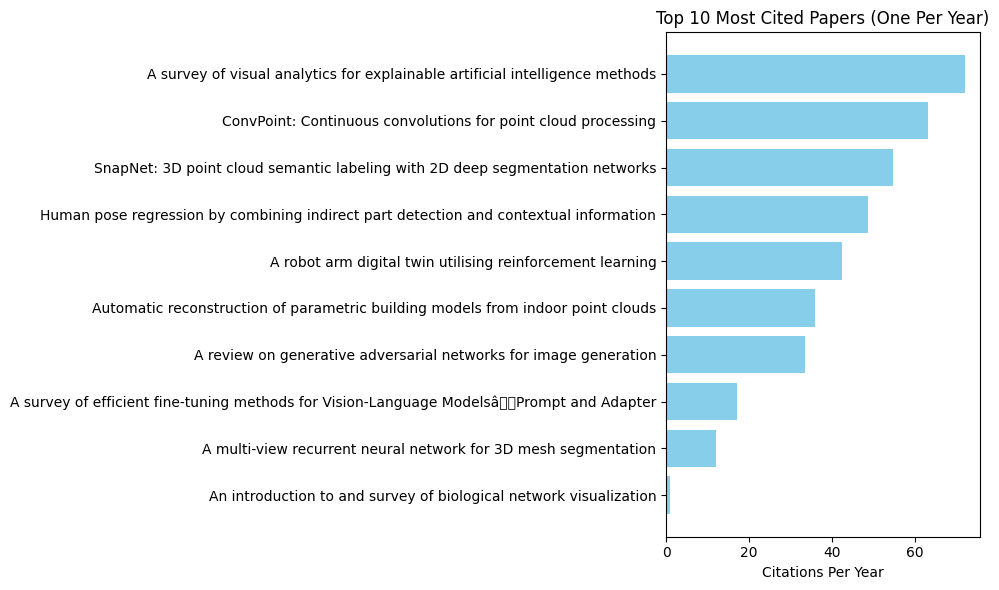

In [53]:
#import matplotlib.pyplot as plt

# Set plot size and style
plt.figure(figsize=(10, 6))
top_10_sorted = top_10.sort_values(by="CitesPerYear")  # So the largest bar is on top

# Plot horizontal bar chart
plt.barh(top_10_sorted["Title"], top_10_sorted["CitesPerYear"], color="skyblue")
plt.xlabel("Citations Per Year")
plt.title("Top 10 Most Cited Papers (One Per Year)")
plt.tight_layout()
plt.show()


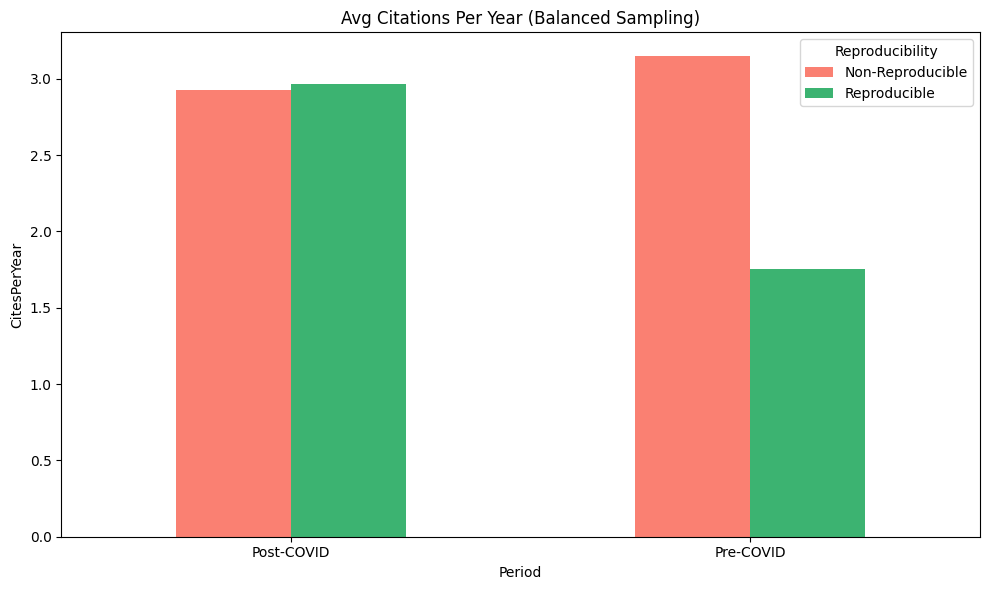

In [54]:
#import pandas as pd
#import matplotlib.pyplot as plt

# Step 1: Add reproducibility and period columns
merged_df["IsReproducible"] = merged_df["DOI"].notna()
merged_df["Period"] = merged_df["Year"].apply(lambda y: "Pre-COVID" if y < 2020 else "Post-COVID")

# Step 2: Balanced sampling function
def sample_equal_group(df, period, sample_size=None):
    subset = df[df["Period"] == period]
    groups = subset.groupby("IsReproducible")
    min_group_size = min(groups.size())

    n = sample_size if sample_size else min_group_size

    reproducible = groups.get_group(True).sample(n=n, random_state=42)
    non_reproducible = groups.get_group(False).sample(n=n, random_state=42)
    
    return pd.concat([reproducible, non_reproducible])

# Step 3: Apply sampling to both periods
sampled_pre = sample_equal_group(merged_df, "Pre-COVID")
sampled_post = sample_equal_group(merged_df, "Post-COVID")

# Step 4: Combine and calculate means
sampled_pre["Period"] = "Pre-COVID"
sampled_post["Period"] = "Post-COVID"
combined_sample = pd.concat([sampled_pre, sampled_post])

avg_citations = (
    combined_sample
    .groupby(["Period", "IsReproducible"])["CitesPerYear"]
    .mean()
    .unstack()
)

# Step 5: Plot
avg_citations.plot(kind="bar", figsize=(10,6), color=["salmon", "mediumseagreen"])
plt.title("Avg Citations Per Year (Balanced Sampling)")
plt.ylabel("CitesPerYear")
plt.xlabel("Period")
plt.xticks(rotation=0)
plt.legend(["Non-Reproducible", "Reproducible"], title="Reproducibility")
plt.tight_layout()
plt.show()


In [55]:
merged_df.columns

Index(['ï»¿Cites', 'Authors', 'Title', 'Year', 'Publisher', 'GSRank',
       'QueryDate', 'Type', 'DOI', 'ECC', 'CitesPerYear', 'CitesPerAuthor',
       'AuthorCount', 'Age', 'Abstract', 'IsReproducible?',
       'CitesPerAuthorPerYear', 'IsReproducible', 'Period'],
      dtype='object')

## Topic Modelling

Bert Topic Modelling Attempts

In [56]:

#from bertopic import BERTopic
#from sentence_transformers import SentenceTransformer

# Load your merged dataset
test_df = pd.read_csv("../notebooks/test.csv", encoding="ISO-8859-1")  

# Filter top 50 papers by CitesPerYear
top_papers = test_df.sort_values(by="CitesPerYear", ascending=False).head(50)


# Drop rows without abstracts
top_papers = top_papers.dropna(subset=["Abstract"])

# Extract abstracts
abstracts = top_papers["Abstract"].tolist()

# Step 7: Apply BERTopic
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=embedding_model, verbose=True)

topics, _ = topic_model.fit_transform(abstracts)

# Add topic labels to your dataframe
top_papers["Topic"] = topics
top_papers["Topic_Label"] = top_papers["Topic"].apply(lambda t: topic_model.get_topic(t))

# View results
top_papers[["Title", "Year", "CitesPerYear", "Topic", "Topic_Label"]]


2025-04-12 16:44:21,871 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]
2025-04-12 16:44:22,266 - BERTopic - Embedding - Completed ✓
2025-04-12 16:44:22,266 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-12 16:44:22,346 - BERTopic - Dimensionality - Completed ✓
2025-04-12 16:44:22,346 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-12 16:44:22,355 - BERTopic - Cluster - Completed ✓
2025-04-12 16:44:22,357 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-12 16:44:22,380 - BERTopic - Representation - Completed ✓


,Title,Year,CitesPerYear,Topic,Topic_Label
737,A survey of visual analytics for explainable a...,2022,72.00,0,"[(of, 0.08392339526279831), (the, 0.0762465437..."
487,ConvPoint: Continuous convolutions for point c...,2020,63.00,0,"[(of, 0.08392339526279831), (the, 0.0762465437..."
205,SnapNet: 3D point cloud semantic labeling with...,2018,54.57,0,"[(of, 0.08392339526279831), (the, 0.0762465437..."
364,Human pose regression by combining indirect pa...,2019,48.67,-1,"[(to, 0.11626242592854028), (techniques, 0.116..."
598,A robot arm digital twin utilising reinforceme...,2021,42.25,-1,"[(to, 0.11626242592854028), (techniques, 0.116..."
594,A comprehensive survey of LIDAR-based 3D objec...,2021,40.75,0,"[(of, 0.08392339526279831), (the, 0.0762465437..."
0,Automatic reconstruction of parametric buildin...,2016,35.78,0,"[(of, 0.08392339526279831), (the, 0.0762465437..."
488,ANU-Net: Attention-based nested U-Net to explo...,2020,34.00,0,"[(of, 0.08392339526279831), (the, 0.0762465437..."
925,A review on generative adversarial networks fo...,2023,33.50,0,"[(of, 0.08392339526279831), (the, 0.0762465437..."
738,Graph neural network-accelerated Lagrangian fl...,2022,31.67,0,"[(of, 0.08392339526279831), (the, 0.0762465437..."


In [57]:
#top 10 keywords for each real topic
print("Topic 0:", topic_model.get_topic(0))
print("Topic 1:", topic_model.get_topic(1))


Topic 0: [('of', np.float64(0.08392339526279831)), ('the', np.float64(0.07624654373426615)), ('for', np.float64(0.07526263592804429)), ('and', np.float64(0.06971063778248877)), ('3d', np.float64(0.06843361605068328)), ('networks', np.float64(0.05399342884404314)), ('as', np.float64(0.04976990258231511)), ('convolutional', np.float64(0.048800832755398954)), ('point', np.float64(0.048800832755398954)), ('an', np.float64(0.04756739222561177))]
Topic 1: [('the', np.float64(0.11512593935564179)), ('to', np.float64(0.09267202417720499)), ('in', np.float64(0.090541098692207)), ('of', np.float64(0.0769355318970722)), ('reality', np.float64(0.07570852564368405)), ('and', np.float64(0.0631543589891261)), ('augmented', np.float64(0.061144190053714874)), ('virtual', np.float64(0.05778922068498583)), ('ar', np.float64(0.05526389889766868)), ('is', np.float64(0.04365266595823726))]


In [58]:
top_papers["IsReproducible"] = top_papers["DOI"].notna()


In [59]:
# Step 1: Import dependencies
#import pandas as pd
#import re
#from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
#from bertopic import BERTopic
#from sentence_transformers import SentenceTransformer

# Step 2: Use the existing merged_df variable

# Step 3: Select top 50 most cited papers
top_papers = test_df.sort_values(by="CitesPerYear", ascending=False).head(50)
top_papers = top_papers.dropna(subset=["Abstract"])

# Step 4: Enhanced text cleaning
custom_stopwords = set(ENGLISH_STOP_WORDS).union({
    "method", "approach", "based", "system", "using", "proposed",
    "results", "data", "model", "paper", "problem", "use"
})

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\b\d+\b", " ", text)  # remove numbers
    text = re.sub(r"\W+", " ", text)      # remove punctuation
    text = " ".join([
        word for word in text.split()
        if word not in custom_stopwords and len(word) > 2
    ])
    return text

top_papers["Cleaned_Abstract"] = top_papers["Abstract"].apply(clean_text)
abstracts = top_papers["Cleaned_Abstract"].tolist()

# Step 5: BERTopic setup and training
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=embedding_model, verbose=True)
topics, _ = topic_model.fit_transform(abstracts)

# Step 6: Assign topics
top_papers["Topic"] = topics
top_papers["Topic_Label"] = top_papers["Topic"].apply(lambda t: topic_model.get_topic(t))

# Step 7: Display topic keywords
for t in sorted(set(topics)):
    if t != -1:
        print(f"\n Topic {t}:")
        for word, score in topic_model.get_topic(t)[:10]:
            print(f"  {word} ({score:.3f})")

# Step 8: View topic assignments
top_papers[["Title", "Year", "CitesPerYear", "Topic", "Topic_Label"]].head(20)


2025-04-12 16:44:25,281 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]
2025-04-12 16:44:25,614 - BERTopic - Embedding - Completed ✓
2025-04-12 16:44:25,614 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-12 16:44:25,695 - BERTopic - Dimensionality - Completed ✓
2025-04-12 16:44:25,698 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-12 16:44:25,704 - BERTopic - Cluster - Completed ✓
2025-04-12 16:44:25,704 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-12 16:44:25,728 - BERTopic - Representation - Completed ✓



 Topic 0:
  reality (0.084)
  virtual (0.073)
  augmented (0.069)
  interaction (0.056)
  user (0.049)
  abstract (0.043)
  environments (0.041)
  human (0.041)
  technology (0.041)
  techniques (0.039)

 Topic 1:
  networks (0.092)
  point (0.083)
  convolutional (0.083)
  deep (0.074)
  neural (0.065)
  models (0.055)
  fluid (0.055)
  shapes (0.052)
  learning (0.052)
  cloud (0.044)


,Title,Year,CitesPerYear,Topic,Topic_Label
737,A survey of visual analytics for explainable a...,2022,72.00,1,"[(networks, 0.0918132358442437), (point, 0.083..."
487,ConvPoint: Continuous convolutions for point c...,2020,63.00,1,"[(networks, 0.0918132358442437), (point, 0.083..."
205,SnapNet: 3D point cloud semantic labeling with...,2018,54.57,1,"[(networks, 0.0918132358442437), (point, 0.083..."
364,Human pose regression by combining indirect pa...,2019,48.67,0,"[(reality, 0.08436754022012546), (virtual, 0.0..."
598,A robot arm digital twin utilising reinforceme...,2021,42.25,-1,"[(dimensional, 0.1764374641425315), (cryo, 0.1..."
594,A comprehensive survey of LIDAR-based 3D objec...,2021,40.75,1,"[(networks, 0.0918132358442437), (point, 0.083..."
0,Automatic reconstruction of parametric buildin...,2016,35.78,1,"[(networks, 0.0918132358442437), (point, 0.083..."
488,ANU-Net: Attention-based nested U-Net to explo...,2020,34.00,1,"[(networks, 0.0918132358442437), (point, 0.083..."
925,A review on generative adversarial networks fo...,2023,33.50,1,"[(networks, 0.0918132358442437), (point, 0.083..."
738,Graph neural network-accelerated Lagrangian fl...,2022,31.67,1,"[(networks, 0.0918132358442437), (point, 0.083..."


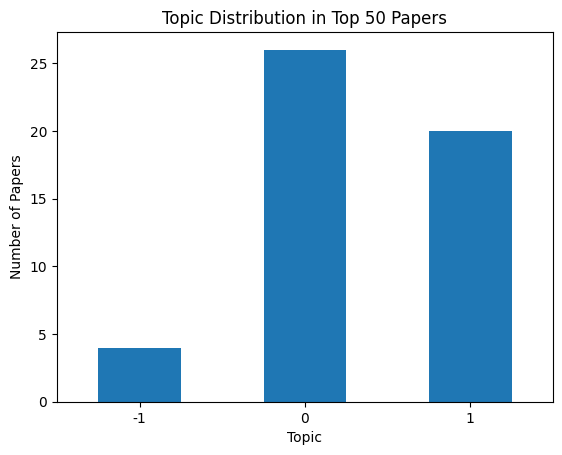

In [60]:
#import matplotlib.pyplot as plt

topic_counts = top_papers['Topic'].value_counts().sort_index()
topic_counts.plot(kind='bar')
plt.title("Topic Distribution in Top 50 Papers")
plt.xlabel("Topic")
plt.ylabel("Number of Papers")
plt.xticks(rotation=0)
plt.show()


In [61]:
def generate_topic_name(topic_model, topic_id, top_n=3):
    if topic_id == -1:
        return "Unclassified"
    keywords = topic_model.get_topic(topic_id)
    if not keywords:
        return "Unclassified"
    # Use the top N keywords to make a descriptive name
    words = [word for word, _ in keywords[:top_n]]
    return " / ".join(words).title()


In [62]:
unique_topics = set(top_papers["Topic"])
topic_name_map = {
    t: generate_topic_name(topic_model, t)
    for t in unique_topics
}


In [63]:
top_papers["Topic_Name"] = top_papers["Topic"].map(topic_name_map)


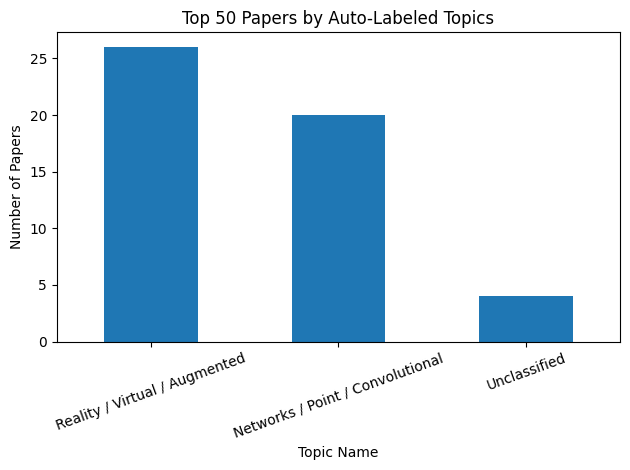

In [64]:
top_papers["Topic_Name"].value_counts().plot(kind="bar")
plt.title("Top 50 Papers by Auto-Labeled Topics")
plt.ylabel("Number of Papers")
plt.xlabel("Topic Name")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


2025-04-12 16:44:29,322 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 42/42 [00:05<00:00,  7.45it/s]
2025-04-12 16:44:34,996 - BERTopic - Embedding - Completed ✓
2025-04-12 16:44:34,997 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-12 16:44:38,141 - BERTopic - Dimensionality - Completed ✓
2025-04-12 16:44:38,141 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-12 16:44:38,239 - BERTopic - Cluster - Completed ✓
2025-04-12 16:44:38,239 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-12 16:44:38,323 - BERTopic - Representation - Completed ✓


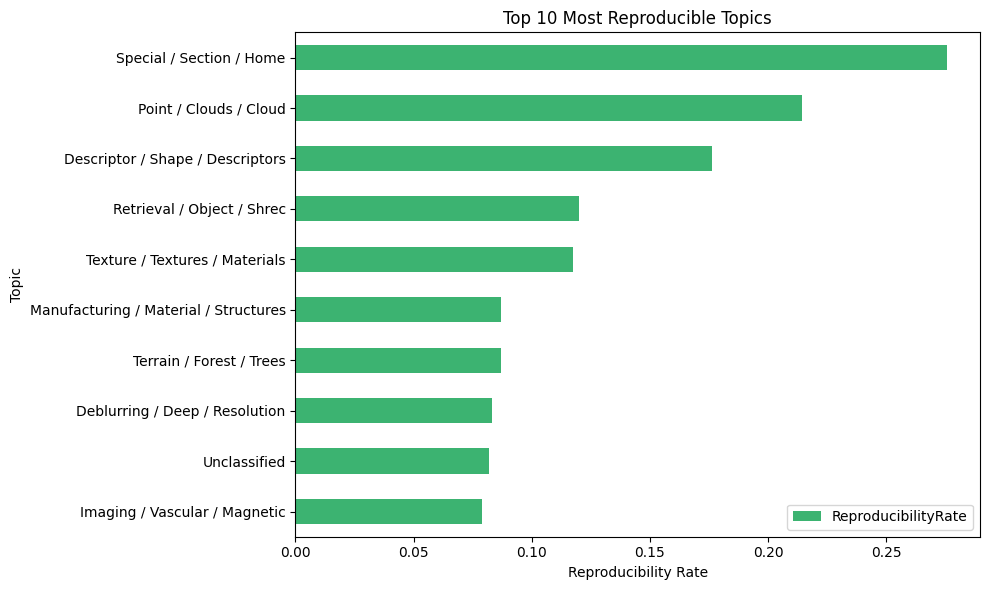

In [65]:
# STEP 1: Imports
#import pandas as pd
#import re
#from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
#from bertopic import BERTopic
#from sentence_transformers import SentenceTransformer
#import matplotlib.pyplot as plt

# STEP 2: Load dataset
# Ensure the correct path to the file is provided
#test_df = pd.read_csv("../notebooks/test.csv", encoding="ISO-8859-1")

# STEP 3: Filter papers with abstracts
top_papers = test_df.dropna(subset=["Abstract"])
top_papers["IsReproducible"] = top_papers["DOI"].notna()

# STEP 4: Clean the abstracts
custom_stopwords = set(ENGLISH_STOP_WORDS).union({
    "method", "approach", "based", "system", "using", "proposed",
    "results", "data", "model", "paper", "problem", "use"
})

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\b\d+\b", " ", text)
    text = re.sub(r"\W+", " ", text)
    text = " ".join([
        word for word in text.split()
        if word not in custom_stopwords and len(word) > 2
    ])
    return text

top_papers["Cleaned_Abstract"] = top_papers["Abstract"].apply(clean_text)
abstracts = top_papers["Cleaned_Abstract"].tolist()

# STEP 5: Apply BERTopic
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=embedding_model, verbose=True)

topics, _ = topic_model.fit_transform(abstracts)
top_papers["Topic"] = topics

# STEP 6: Generate topic names
def generate_topic_name(topic_model, topic_id, top_n=3):
    if topic_id == -1:
        return "Unclassified"
    keywords = topic_model.get_topic(topic_id)
    if not keywords:
        return "Unclassified"
    words = [word for word, _ in keywords[:top_n]]
    return " / ".join(words).title()

unique_topics = set(topics)
topic_name_map = {t: generate_topic_name(topic_model, t) for t in unique_topics}
top_papers["Topic_Name"] = top_papers["Topic"].map(topic_name_map)

# STEP 7: Analyze reproducibility by topic
topic_reproducibility = (
    top_papers.groupby("Topic")["IsReproducible"]
    .agg(["count", "sum"])
    .rename(columns={"count": "Total", "sum": "Reproducible"})
)
topic_reproducibility["ReproducibilityRate"] = topic_reproducibility["Reproducible"] / topic_reproducibility["Total"]
topic_reproducibility["Topic_Name"] = topic_reproducibility.index.map(topic_name_map)
topic_reproducibility_sorted = topic_reproducibility.sort_values(by="ReproducibilityRate", ascending=False)

# STEP 8: Visualize top reproducible topics
topic_reproducibility_sorted.head(10).plot(
    kind="barh", x="Topic_Name", y="ReproducibilityRate", figsize=(10, 6), color="mediumseagreen"
)
plt.title("Top 10 Most Reproducible Topics")
plt.xlabel("Reproducibility Rate")
plt.ylabel("Topic")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


LDA Topic Modelling

In [66]:
#import pandas as pd
#import nltk
#from nltk.corpus import stopwords
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.decomposition import LatentDirichletAllocation
#import matplotlib.pyplot as plt
#import seaborn as sns

# Download stopwords
nltk.download('stopwords')

df = pd.read_csv('./test.csv', encoding='ISO-8859-1')

TEXT_COLUMN = 'Abstract'  

# Define custom stopwords
custom_stopwords = stopwords.words('english') + [
    'based', 'using', 'multi', 'special', 'section', 'real', 'data', 'time',
    'model', 'models', 'image', 'images', '3d', 'approach', 'method', 'methods', 'results'
]

# Clean text function
def clean_text(text):
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in custom_stopwords]
    return ' '.join(tokens)

# Apply cleaning
df['cleaned_text'] = df[TEXT_COLUMN].astype(str).apply(clean_text)


# 4. TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_text'])


# 5. Train LDA Model
NUM_TOPICS = 5
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, random_state=42)
lda.fit(dtm)


# 6. Print Top Keywords per Topic
words = vectorizer.get_feature_names_out()

print("\n Top Words Per Topic:")
for topic_idx, topic in enumerate(lda.components_):
    print(f"\n Topic {topic_idx}:")
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [words[i] for i in top_words_idx]
    print(", ".join(top_words))
    print("-" * 50)


# 7. Assign Topics to Papers
topic_values = lda.transform(dtm)
df['AssignedTopic'] = topic_values.argmax(axis=1)


# 8. Map Topics to Real Names
topic_mapping = {
    0: 'Deep Learning for 3D Reconstruction',
    1: '3D Point Cloud and Surface Modeling',
    2: 'Virtual Reality and Interactive Environments',
    3: 'Particle-based Fluid Simulation',
    4: 'Real-Time Graphics Rendering Techniques'
}

df['TopicName'] = df['AssignedTopic'].map(topic_mapping)





[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\senut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



 Top Words Per Topic:

 Topic 0:
reality, light, vr, head, abstract, virtual, paper, augmented, surface, present
--------------------------------------------------

 Topic 1:
graphics, paper, computer, virtual, shape, human, present, skip, abstract, range
--------------------------------------------------

 Topic 2:
virtual, reality, computer, abstract, visualization, objects, paper, training, present, interaction
--------------------------------------------------

 Topic 3:
learning, point, deep, surface, computer, based, paper, design, networks, multi
--------------------------------------------------

 Topic 4:
nan, shape, existing, shapes, point, propose, process, facial, paper, topological
--------------------------------------------------



 Table: Papers per Topic Categorized by Reproducibility
                                              Non-Reproducible  Reproducible
TopicName                                                                   
3D Point Cloud and Surface Modeling                        322            27
Deep Learning for 3D Reconstruction                        185            12
Particle-based Fluid Simulation                            286            27
Real-Time Graphics Rendering Techniques                    253            10
Virtual Reality and Interactive Environments               266            12


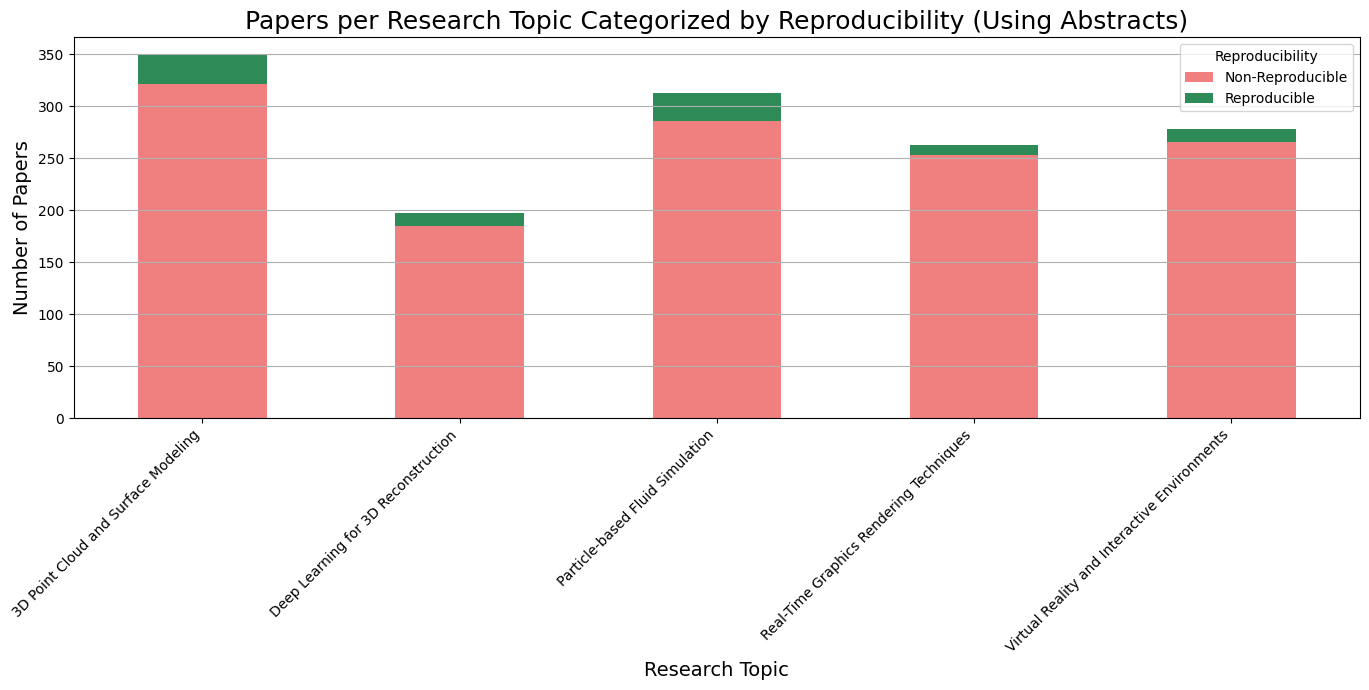

In [67]:
# 11. Table 2: Print Paper Count per Topic Split by Reproducibility
if 'IsReproducible?' not in df.columns:
    print("⚠️ Warning: 'IsReproducible?' column not found in your dataset.")

# Group and count
topic_reproducibility_counts = df.groupby(['TopicName', 'IsReproducible?']).size().unstack(fill_value=0)

# Rename columns
topic_reproducibility_counts.columns = ['Non-Reproducible', 'Reproducible']

# Print the reproducibility split table
print("\n Table: Papers per Topic Categorized by Reproducibility")
print(topic_reproducibility_counts)


# 12. Plot Stacked Bar Chart Including Reproducibility
topic_reproducibility_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(14,7),
    color=['lightcoral', 'seagreen']
)

plt.title('Papers per Research Topic Categorized by Reproducibility (Using Abstracts)', fontsize=18)
plt.xlabel('Research Topic', fontsize=14)
plt.ylabel('Number of Papers', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Reproducibility')
plt.grid(axis='y')
plt.tight_layout()
